# Short Term Water Demand Forecasting with Statistical and AI Methods

### Oscar Wooding
Department of Civil and Environmental Engineering, Imperial College London

### Initial Statistical Analysis


In [88]:
# imports 
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
import matplotlib_inline
import datetime as dt
import warnings
from scipy import stats

from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import MSTL
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# improve matlab output
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

rc('text', usetex=False)
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=11)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# adjust the format of the data set
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

warnings.filterwarnings("ignore")


### *Load*

In [63]:
# load inflow data
inflow_data = pd.read_csv("../data/InflowData.csv")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('date_time')

# change index format to datetime
inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")

# # print first two rows
inflow_data.head(3)


dma_a  dma_b  dma_c  dma_d  dma_e  dma_f  dma_g  dma_h  \
date_time                                                                     
2021-01-01 00:00:00    NaN    NaN   3.70    NaN    NaN    NaN    NaN    NaN   
2021-01-01 01:00:00    NaN    NaN   3.56    NaN    NaN    NaN    NaN    NaN   
2021-01-01 02:00:00    NaN    NaN   3.27    NaN    NaN    NaN    NaN    NaN   

                     dma_i  dma_j  
date_time                          
2021-01-01 00:00:00    NaN    NaN  
2021-01-01 01:00:00    NaN    NaN  
2021-01-01 02:00:00    NaN    NaN

In [64]:
# load weather data
weather_data = pd.read_csv("../data/WeatherData.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('date_time')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index, format="%d/%m/%Y %H:%M")

weather_data_imputed = weather_data.fillna(method='bfill')

# # print first two rows
weather_data_imputed.head(3)

rain_depth  air_temp  air_humid  windspeed
date_time                                                      
2021-01-01 00:00:00        0.00      7.20      79.00       9.00
2021-01-01 01:00:00        0.00      7.30      79.00       6.00
2021-01-01 02:00:00        0.00      7.60      78.00       4.00

In [65]:
# visualise missing data
fig, axs = plt.subplots(11, 1, figsize=(12, 24))

colors = [
    "#ff7f0e",  # Orange
    "#1f77b4",  # Blue
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#8c564b",  # Brown
    "#e377c2",  # Pink
    "#7f7f7f",  # Gray
    "#bcbd22",  # Yellow-Green
    "#17becf"   # Cyan
]

for i, col in enumerate(inflow_data.columns): 
    axs[i].plot(inflow_data[col], label=col)
    
    for index, row in inflow_data[inflow_data[col].isna()==True][[col]].iterrows(): 
        if row.isna().sum() / len(row) > 0.5: 
            axs[i].axvline(x=index, ymin=0, ymax=1, color='r')
            axs[10].axvline(x=index, ymin=i/10, ymax=(i+1)/10, color=colors[i], label=col)
    
    perc_data_missing = inflow_data[col].isna().sum() / len(inflow_data[col])
    axs[i].set_title(f"{col} : perc. data missing - {perc_data_missing:.2f}")
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Demand')

axs[10].set_title('Comparison of missing data')
axs[10].set_xlabel('Date')
axs[10].set_xlim(inflow_data.index[0], inflow_data.index[-1])

fig.tight_layout()
plt.show()

### Comment on Missing Data

- Most of the dmas have a large portion of missing data 
- Large missing blocks are very difficult to impute accurately, alternative measures should be used or data removed
- Data missing in different patterns across all dmas, however there is still a large amount of overlap
- 

### Imputing Techniques

#### 1. Deletion

Deletion is appropriate when the amount of missing data is very small, such that it represents a negligible portion of the total dataset. It is also used when the missing data is Missing Completely at Random (MCAR), meaning that there are no patterns in the missing data.

In [7]:
# deletion 

# 

#### 2. Last Observation Carried Forward / Next Observation Carried Backwards

LOCF can be useful in time-series data where there is a trend or pattern that continues from one time point to the next. It’s also useful when the data is collected at regular intervals, and the values are relatively stable or change slowly over time.

#### 3. Mean / Median Day Fill

Mean/Median/Mode imputation can be used when the data is missing completely at random (MCAR). If the missing data is not random, this method can lead to biased and inefficient estimates.

Mean/Median/Mode imputation can lead to an underestimate of the variance, which can lead to biased estimates of the covariances and correlations. This can affect the model’s ability to accurately capture the relationships between variables. Therefore, it’s important to carefully consider the nature of the missing data before using this method.

#### 4. Rolling Statistics

Rolling Statistics Imputation is particularly effective for time series data with temporal dependencies. It can handle situations where the missing data is Missing At Random (MAR) or Not Missing At Random (NMAR). This method assumes that nearby points in time are more similar to each other, which often holds true for time series data.

In [8]:
# Make a copy of the original DataFrame
df_copy = df.copy()

# Mark the missing values before imputation
imputed_indices = df_copy[df_copy['sales'].isnull()].index


# Apply the rolling mean imputation method
df_copy['sales'] = df_copy['sales'].fillna(df_copy['sales'].rolling(window=4, min_periods=1).mean().shift(1))

# Plot the main line with markers
df_copy['sales'].plot(style='.-', figsize=(12,8), title='Sales with Rolling Mean Imputation')

# Add points where data was imputed with red color
plt.scatter(imputed_indices, df_copy.loc[imputed_indices, 'sales'], color='red')

# Set labels
plt.xlabel('Time')
plt.ylabel('Sales')

plt.show()

NameError: name 'df' is not defined

#### 5. Linear Interpolation

Linear interpolation is suitable when the data shows a linear trend between the observations. It’s not suitable for data that shows a nonlinear trend or seasonal pattern as it will almost distort the seasonal pattern at all.

#### 6. Spline Interpolation

Spline interpolation is used when the data is numeric and continuous, and you want to avoid the problem of overfitting that can occur with polynomial interpolation. Provides a smoother fit than linear interpolation. 

In [9]:
# Apply the spline interpolation method
df_imputed = df.interpolate(method='spline', limit_direction='forward', order=2)

# Plot the main line with markers
df_imputed['sales'].plot(style='.-', figsize=(12,8), title='Sales with Spline Interpolation')

# Add points where data was imputed with red color
imputed_indices = df[df['sales'].isnull()].index
plt.scatter(imputed_indices, df_imputed.loc[imputed_indices, 'sales'], color='red')

# Set labels
plt.xlabel('Time')
plt.ylabel('Sales')

plt.show()

NameError: name 'df' is not defined

#### 7. Regression Imputation

Regression imputation can be used when the data is numeric and there is a strong correlation between the variable with missing values and other variables. Makes use of the relationship between variables.

Regression imputation can lead to more accurate models by making use of the relationships between variables. However, it can also lead to an overestimate of the correlation between variables, which can affect the model’s performance.


In [10]:
## Unfinished
# Find comparison partner
df = inflow_data.copy()
correlation = df[df.index[-1]-dt.timedelta(weeks=12)::].corr()
correlation = correlation[correlation!=1]
partners = {
    dma: correlation[(correlation[dma]==correlation[dma].max())].index[0] 
    for dma in correlation.columns
}

# Drop missing values to fit the regression model
df_imputed = df.copy()
df_non_missing = df.dropna()

# Instantiate the model
model = LinearRegression()

# Reshape data for model fitting (sklearn requires 2D array for predictors)
X = df_non_missing['ad_spent'].values.reshape(-1, 1)
Y = df_non_missing['sales'].values

# Fit the model
model.fit(X, Y)

# Get indices of missing sales
missing_sales_indices = df_imputed[df_imputed['sales'].isnull()].index

# Predict missing sales values
predicted_sales = model.predict(df_imputed.loc[missing_sales_indices, 'ad_spent'].values.reshape(-1, 1))

# Fill missing sales with predicted values
df_imputed.loc[missing_sales_indices, 'sales'] = predicted_sales

# Plot the main line with markers
df_imputed[['sales']].plot(style='.-', figsize=(12,8), title='Sales with Regression Imputation')

# Add points where data was imputed with red color
plt.scatter(missing_sales_indices, predicted_sales, color='red', label='Regression Imputation')

# Set labels
plt.xlabel('Time')
plt.ylabel('Sales')

plt.show()

NameError: name 'LinearRegression' is not defined

#### 8. KNN 

The KNN imputation method works by finding the K-nearest neighbors to the observation with missing data and then imputing them based on the non-missing values in the neighbors. KNN can be used when the data are missing at random, and the variables are almost equally important. KNN is better when the data are uniformly distributed, and it’s not suitable for high dimensional data.

KNN imputation can introduce bias into the data if the missing data mechanism isn’t random. This is because the KNN algorithm relies on the assumption that similar observations exist in the dataset. If this assumption is violated, the imputed values may be far from the true values, leading to biased estimates in the model-building process.

#### *Methodology*

1. Find comparison partner to regress against by considering highest correlation (across past 3 months) pair for chosen dma.  
2. KNN Imputation with correlated partner. 

#### *Thoughts*

- Try based on weather / temp. 

In [162]:
# Mean Day Impute
def MeanDayImpute(df, dma, lag=5, memory=0.4, res_window=10): 
    """
    Fills missing data values with the average for that day 
    calcuated as an exponential average of the past (lag)
    occurances for that time and day.
    
    df - total dataframe of all dma
    dma - dma of interest
    lag - number of past values averaged
    memory - importance of recent values
    res_window - window used to average rolling residual
    
    """
    
    # exponential mean component
    avg_df = df[[dma]].copy() 
    avg_df['mean'] = 0
    
    for delta in np.arange(lag, 0, -1):
        avg_df[dma+str(delta)] = avg_df[dma].shift(24*7*delta)
        
        if delta == lag: 
            avg_df['mean'] = avg_df[dma+str(delta)]
        else:
            avg_df['mean'] = avg_df['mean']*(1-memory) + avg_df[dma+str(delta)]*memory
        
    # fill with nan mean for insufficient data for exponential
    avg_df['day'] = avg_df.index.day
    avg_df['hour'] = avg_df.index.hour
    avg_values = avg_df.groupby(by=['day', 'hour']).mean()[dma]
    
    # residual correction component
    avg_df['residual'] = avg_df[dma] - avg_df['mean']
    avg_df['res_correction'] = avg_df['residual'].rolling(window=res_window, min_periods=1, win_type='exponential').mean()
    avg_df['mean'] = avg_df['mean'] + avg_df['res_correction'].fillna(0)
    
    for idx in avg_df[avg_df['mean'].isna()].index: 
        avg_df.loc[idx, 'mean'] = avg_values.loc[idx.day, idx.hour]
    
    
    return avg_df['mean']


# Correlation Partners
def CorrPartner(data, thresh=0.7, period=12):
    """
    Finds dmas which have a correlation over the threshold
    across the specified period in weeks
    
    thresh - correlation threshold for partner to be considered
    period - number of weeks to consider correlation over
    
    """
    # Find comparison partner
    df = data.copy()
    correlation = df[df.index[-1]-dt.timedelta(weeks=period)::].corr()
    correlation = correlation[correlation!=1]
    partners = {
        dma: list(correlation[(correlation[dma]>=thresh)].index) 
        for dma in correlation.columns
    }
    
    return partners

def KmeanImpute(df, dma, partners, k=3): 
    """
    Imputes data using k means alogrithm for correlated dmas
    
    df - dataframe to impute
    k - number of neighbours
    dma - dma to impute
    
    """
    # Initialize the KNN imputer with k=5
    imputer = KNNImputer(n_neighbors=k)
    cols = partners[dma]+[dma]  # correlated partner set
    
    return imputer.fit_transform(df[cols])
    

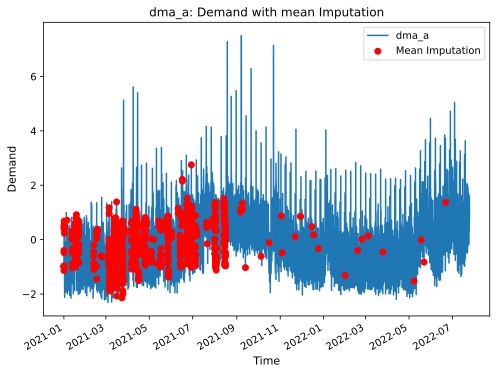

In [165]:
# testing
df_ini = inflow_data.copy()
df = df_ini.copy()

# normalise 
for dma in df.columns: 
    # extract vals
    values = df[dma].values
    values = values.reshape((len(values), 1))

    # train the standardization
    scaler_std = StandardScaler()
    scaler_std = scaler_std.fit(values)
    standardized = scaler_std.transform(values)
    
    df[dma] = standardized.flatten()

# get correlation partners
partners = CorrPartner(df, thresh=0.9, period=12)
missing_dma_indices = {}

# Fill first with average day where partners both have nan value
for dma in df.columns: 
    # where partner data not available replace with avg.
    cols = partners[dma]+[dma]  # correlated partner set
    missing_dma_indices[dma] = df[df[cols].isna().all(axis=1)].index
    df.loc[missing_dma_indices[dma], dma] = MeanDayImpute(df, dma, res_window=3)[missing_dma_indices[dma]]

    
# Plot initial mean values filled
dma = 'dma_a'
plt.figure(figsize=(8, 6))
df[dma].plot(style='-', label=dma, zorder=0)

# Add points where data was imputed
plt.scatter(missing_dma_indices[dma], df.loc[missing_dma_indices[dma], dma], color='red', label='Mean Imputation', zorder=1)

# Set title and labels
plt.title(f"{dma}: Demand with mean Imputation")
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()


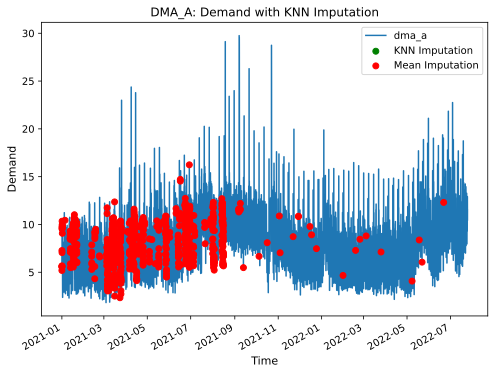

In [166]:
# Apply the KNN imputer
# Note: the KNNImputer requires 2D array-like input, hence the double brackets.
df_imputed = df.copy()
imputed_indices = {}

for dma in df_imputed.columns: 
    imputed_indices[dma] = df[df[dma].isna()].index
    df_imputed[partners[dma]+[dma]] = KmeanImpute(df, dma, partners, k=3)

# transform back
for dma in df.columns: 
    # extract vals
    values = df_ini[dma].values
    values = values.reshape((len(values), 1))
    
    std_values = df_imputed[dma].values
    std_values = std_values.reshape((len(std_values), 1))

    # train the standardization
    scaler_std = scaler_std.fit(values)
    standardized = scaler_std.inverse_transform(std_values)
    
    df_imputed[dma] = standardized.flatten()

# Create a plot of all imputed values
dma = 'dma_a'
plt.figure(figsize=(8,6))
df_imputed[dma].plot(style='-', label=dma, zorder=0)


# Add points where data was imputed
plt.scatter(imputed_indices[dma], df_imputed.loc[imputed_indices[dma], dma], color='green', label='KNN Imputation', zorder=2)
plt.scatter(missing_dma_indices[dma], df_imputed.loc[missing_dma_indices[dma], dma], color='red', label='Mean Imputation', zorder=1)

# Set title and labels
plt.title(f"DMA_A: Demand with KNN Imputation")
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()


#### 9. Seasonal Trend Decomposition using Loess Imputation

Seasonal Trend decomposition using Loess (STL) is a statistical method for decomposing a time series into three components: trend, seasonal, and remainder (random). It can be used for imputing missing data in a time series. In the STL imputation method, the missing values are initially estimated via interpolation to allow for STL decomposition. Afterward, the seasonal and trend components of the decomposed time series are extracted. The missing values are then re-estimated by interpolating the trend component and re-adding the seasonal component.

STL imputation can be used when dealing with time series data that exhibits a seasonal pattern. It is particularly useful when the data are missing at random and the missingness is not related to the trend or seasonality of the time series.

In [14]:
# POSSIBLY USELESS
# Make a copy of the original dataframe
df_copy = df_ini.copy()

for dma in df_imputed.columns: 
    # Apply STL decompostion
    stl = MSTL(df_imputed[dma].values.reshape(-1), periods=(24, 24*7))
    res = stl.fit()
    
    # Extract the seasonal and trend components
    seasonal_component = res.seasonal.sum(axis=1)

    # Create the deseasonalised series
    df_deseasonalised = df_copy[dma] - seasonal_component

    # Interpolate missing values in the deseasonalised series
    df_deseasonalised_imputed = df_deseasonalised.interpolate(method="linear")

    # Add the seasonal component back to create the final imputed series
    df_imputed[dma] = df_deseasonalised_imputed + seasonal_component

    # Update the original dataframe with the imputed values
    df_copy.loc[missing_dma_indices[dma], dma] = df_imputed[missing_dma_indices[dma]]


KeyError: "None of [DatetimeIndex(['2021-05-26 21:00:00', '2021-05-26 22:00:00',\n               '2021-05-26 23:00:00', '2021-05-27 00:00:00',\n               '2021-05-27 01:00:00', '2021-05-27 02:00:00',\n               '2021-05-27 03:00:00', '2021-05-27 13:00:00',\n               '2021-05-27 14:00:00', '2021-05-27 15:00:00',\n               ...\n               '2021-07-05 10:00:00', '2021-07-05 11:00:00',\n               '2021-07-06 18:00:00', '2021-07-06 19:00:00',\n               '2021-07-20 14:00:00', '2021-07-20 15:00:00',\n               '2021-07-21 06:00:00', '2021-07-21 07:00:00',\n               '2021-07-27 10:00:00', '2021-07-27 11:00:00'],\n              dtype='datetime64[ns]', name='date_time', length=143, freq=None)] are in the [columns]"

### Save Data

In [167]:
df_imputed.to_csv('../data/InflowDataImputed.csv')
weather_data_imputed.to_csv('../data/WeatherDataImputed.csv')
